<p style="text-align: center; font-size:50px;">RNN with sequential data</p>

#### This notebook is a follow-up to the "About RNN" notebook. 
#### In this notebook, instead of a textual data, I will be utilizing price data from a particular stock and showcase what a simple RNN model is capable of. 
#### I wish to showcase what a RNN model is capable of and the limitations of it. 

<p style="text-align: center; font-size:30px;">Data Preparation</p>

#### We will utilize historical data of the S&P index for the last 5 years.

In [84]:
import yfinance as yf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
import torch  
import torch.nn as nn  
import torchinfo
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

In [85]:
start_date = '2018-01-01' 
end_date = '2023-01-01' 

ticker = 'SPY' 

data = yf.download(ticker, start_date, end_date) 

print(data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-02  267.839996  268.809998  267.399994  268.769989  245.828461   
2018-01-03  268.959991  270.640015  268.959991  270.470001  247.383347   
2018-01-04  271.200012  272.160004  270.540009  271.609985  248.425934   
2018-01-05  272.510010  273.559998  271.950012  273.420013  250.081558   
2018-01-08  273.309998  274.100006  272.980011  273.920013  250.538895   
...                ...         ...         ...         ...         ...   
2022-12-23  379.649994  383.059998  378.029999  382.910004  381.454193   
2022-12-27  382.790009  383.149994  379.649994  381.399994  379.949921   
2022-12-28  381.329987  383.390015  376.420013  376.660004  375.227936   
2022-12-29  379.630005  384.350006  379.079987  383.440002  381.982178   
2022-12-30  380.640015  382.579987  378.429

#### For our case, we will utilize the 'Adj Close' values.

In [86]:
data = data[['Adj Close']]
data.head()

,Adj Close
Date,
2018-01-02,245.828461
2018-01-03,247.383347
2018-01-04,248.425934
2018-01-05,250.081558
2018-01-08,250.538895


#### Let's take a look at what the graph looks like.

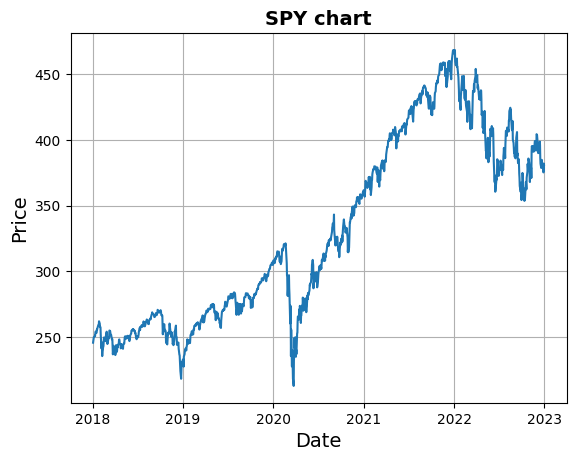

In [87]:
fig, ax = plt.subplots()

ax.plot(data['Adj Close']) 
ax.set_ylabel("Price", fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('SPY chart', fontweight='bold', fontsize=14)
ax.grid(True)

plt.show()

#### Now, let us prepare the data into the format we want to feed into our model. 
#### We will utilize the past 20 data points to predict the next day's price. 

In [88]:
# Scaling data

scaler = MinMaxScaler(feature_range=(-1,1))
original_data = data.copy()
data['Adj Close'] = scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))

/var/folders/g6/g9hyk9sx7nsbmqrzpj5z10fc0000gn/T/ipykernel_6927/4055025686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Adj Close'] = scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))


In [89]:
seq_len = 20 
batch_size = 16 

input_arr = [] # Will contain past 20 data points
target_arr = [] # Will contain the price of the next day

for i in tqdm(range(0,data.shape[0]-21)):
    input_arr.append(np.array(data.iloc[i:i+20]))
    target_arr.append(data.iloc[i+21].values)

100%|██████████| 1238/1238 [00:00<00:00, 27067.22it/s]


#### Let's take a look at our data.

In [90]:
print(f"This is the first input: {input_arr[0]}")
print(f"There are {len(input_arr[0])} number of values for the first input\n")
print(f"This is the target: {target_arr[0]}")

This is the first input: [[-0.74263421]
 [-0.73045449]
 [-0.72228771]
 [-0.70931889]
 [-0.70573648]
 [-0.70129434]
 [-0.70430398]
 [-0.68997508]
 [-0.67707833]
 [-0.6838848 ]
 [-0.66497069]
 [-0.66833747]
 [-0.65923898]
 [-0.64290374]
 [-0.63860443]
 [-0.63939329]
 [-0.63853319]
 [-0.61503338]
 [-0.62864584]
 [-0.64956678]]
There are 20 number of values for the first input

This is the target: [-0.65085574]


#### Ok! It seems like the data is in the shape that we wanted. 
#### Let's make them into torch tensors first.

In [91]:
input_arr = torch.from_numpy(np.array(input_arr).astype('float32')) 
target_arr = torch.from_numpy(np.array(target_arr).astype('float32'))

#### Before we proceed on, let's take the final step and divide them up into training and validation sets. 
#### We are not supposed to shuffle the datasets in time series problems to prevent the model from looking forward into the future. 
#### So, we will divide up the dataset by simple indexing.

In [92]:
cut_off = int(input_arr.shape[0] * 0.7)

train_input_arr = input_arr[:cut_off]
validation_input_arr = input_arr[cut_off:]
train_target_arr = target_arr[:cut_off] 
validation_target_arr = target_arr[cut_off:]

In [93]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = X 
        self.y = y

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        
        return self.X[idx], self.y[idx]

train_data = dataset(train_input_arr, train_target_arr) 
val_data = dataset(validation_input_arr, validation_target_arr)

train = DataLoader(dataset=train_data, 
                                     batch_size=batch_size, 
                                     shuffle=False) 

val = DataLoader(dataset=val_data, 
                                    batch_size=batch_size, 
                                    shuffle=False) 

X, y = next(iter(train))
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: torch.Size([16, 20, 1])
Shape of y: torch.Size([16, 1])


<p style="text-align: center; font-size:30px;">Modeling</p>

#### Now that our data is set, let us proceed onto define our model. 

In [94]:
device = torch.device('mps') 
device # Since I'm using a M2 Chip

device(type='mps')

#### For the syntax of the nn.RNN module, please read up on the official PyTorch website [here](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

In [95]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers 

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True) 
        self.fc = nn.Linear(hidden_dim*seq_len, output_size) 

    def forward(self, x):

        batch_size = x.size(0) # Since we used batch_first = True

        hidden = self.init__hidden(batch_size) 

        out, hidden = self.rnn(x,hidden) 
        out = out.contiguous().view(batch_size, -1) 
        out = self.fc(out) 

        return out, hidden 

    def init__hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim, device = device) 
        return hidden 

model = Model(input_size=1, output_size = 1, hidden_dim = 12, n_layers = 1).to(device)

torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─RNN: 1-1                               180
├─Linear: 1-2                            241
Total params: 421
Trainable params: 421
Non-trainable params: 0

#### Now let's define our loss criterion, optimizers, number of epochs and the learning rate.

In [96]:
lr = 0.001 
n_epochs = 100 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr) 

#### Let's run our training loop now.

In [97]:
train_loss_arr = []
test_loss_arr = []

for epoch in tqdm(range(1, n_epochs + 1)):
    # Training 
    train_loss = 0 

    for batch, (X,y) in enumerate(train): 
        X = X.to(device) 
        y = y.to(device) 
        model = model.train() 

        y_pred, hidden = model(X)

        # Calculate loss
        loss = criterion(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss/=len(train)
    train_loss_arr.append(train_loss.cpu().detach().numpy())

    # Validation
    test_loss = 0
    model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(val):

            X = X.to(device)
            y = y.to(device)
            
            # Forward
            y_pred, hidden = model(X)
            
            # Calculate loss 
            test_loss += criterion(y_pred, y)
            
            
        test_loss /= len(val)
        test_loss_arr.append(test_loss.cpu().detach().numpy())
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Training Loss: {:.4f}".format(train_loss.item()))
        print("Validation Loss: {:.4f}".format(test_loss.item()))

 10%|█         | 10/100 [00:08<01:20,  1.12it/s]

Epoch: 10/100............. Training Loss: 0.0069
Validation Loss: 0.0137


 20%|██        | 20/100 [00:17<01:09,  1.14it/s]

Epoch: 20/100............. Training Loss: 0.0049
Validation Loss: 0.0093


 30%|███       | 30/100 [00:26<01:01,  1.14it/s]

Epoch: 30/100............. Training Loss: 0.0039
Validation Loss: 0.0067


 40%|████      | 40/100 [00:35<00:52,  1.14it/s]

Epoch: 40/100............. Training Loss: 0.0036
Validation Loss: 0.0058


 50%|█████     | 50/100 [00:43<00:43,  1.14it/s]

Epoch: 50/100............. Training Loss: 0.0033
Validation Loss: 0.0054


 60%|██████    | 60/100 [00:52<00:34,  1.15it/s]

Epoch: 60/100............. Training Loss: 0.0030
Validation Loss: 0.0052


 70%|███████   | 70/100 [01:01<00:26,  1.15it/s]

Epoch: 70/100............. Training Loss: 0.0028
Validation Loss: 0.0048


 80%|████████  | 80/100 [01:10<00:17,  1.15it/s]

Epoch: 80/100............. Training Loss: 0.0026
Validation Loss: 0.0044


 90%|█████████ | 90/100 [01:18<00:08,  1.16it/s]

Epoch: 90/100............. Training Loss: 0.0025
Validation Loss: 0.0042


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]

Epoch: 100/100............. Training Loss: 0.0024
Validation Loss: 0.0040


#### We can take a look at the progress.

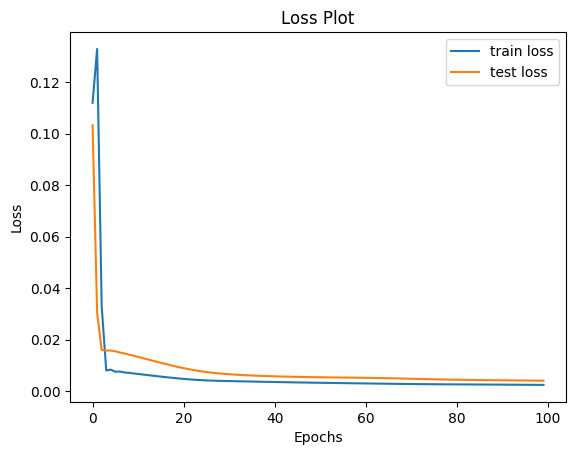

In [98]:
plt.plot([i for i in range(n_epochs)], train_loss_arr, label='train loss')
plt.plot([i for i in range(n_epochs)], test_loss_arr, label='test loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#### Well it seems like we have reached a plateau in training. 

#### Let's take a look at how well the model predicts on the validation set.

In [111]:
pred_val = []

model.eval() 
with torch.inference_mode():
    for batch, (X,y) in enumerate(val):

        X = X.to(device)
        y = y.to(device)
            
        # Forward
        y_pred, hidden = model(X)

        pred_val.append(y_pred.cpu().detach().numpy())

pred_arr = []
for i in pred_val:
    pred_arr.append(scaler.inverse_transform(i))

# Contains the predictions inverse transformed for the validation set
pred_arr_flat = [float(item) for sublist in pred_arr for item in sublist]

In [114]:
validation_data = original_data.iloc[866+21:866+21+372].copy()
validation_data['pred'] = pred_arr_flat
validation_data

,Adj Close,pred
Date,,
2021-07-13,424.152618,422.932770
2021-07-14,424.785583,425.616699
2021-07-15,423.334747,426.061096
2021-07-16,420.014282,425.498474
2021-07-19,413.811523,424.541138
...,...,...
2022-12-23,381.454193,386.613770
2022-12-27,379.949921,384.894531
2022-12-28,375.227936,382.674744


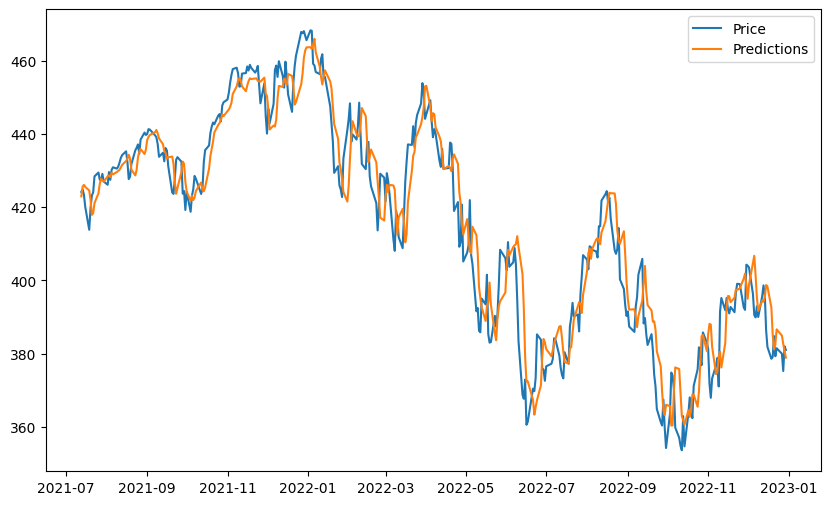

In [115]:
plt.figure(figsize=(10,6))
plt.plot(validation_data['Adj Close'], label = 'Price')
plt.plot(validation_data['pred'], label = 'Predictions')
plt.legend()
plt.show()

#### As we can see, the predictions are pretty close. 
#### However, we can definitely observe some lag with the price movements. 

<p style="text-align: center; font-size:30px;">Conclusion</p>

#### Obviously, this model won't give us back the most accurate predictions. 
#### Price predictions are not as easy as it sounds as in the real world, it is affected by a myriad of factors. 
#### The model's complexity won't be able to capture all the details and a simple RNN is not complex enough. 
#### Next time, I will showcase the power of other forms of the RNN network such as LSTU and GRUs. 
#### See you next time!